In [1]:
# # Import standard libraries
# import requests
import time
import dill
time.sleep(3)

from urllib.request import urlopen

# # Import third-party libraries
# import geopandas as gpd
from geoalchemy2 import Geometry
from geoalchemy2.shape import from_shape
import pandas as pd
import sqlalchemy as sa
from sqlalchemy import create_engine, Column, Integer, String, Date, MetaData, event, Table, text, LargeBinary, ForeignKey
from sqlalchemy.dialects.sqlite import insert
from sqlalchemy.orm import sessionmaker
import geopandas as gpd

pluto_version = "25v1_1"


* #### Load the objects created in previous notebooks

In [2]:
# Load the environment
with open("environment_data/table_dicts.pkl", "rb") as f:
    env = dill.load(f)

# Restore the environment
globals().update(env)

In [3]:
engine = create_engine(f'{SQLITE_PATH}?check_same_thread=False', echo=False)

SessionLocal = sessionmaker(bind=engine, autoflush=False, autocommit=False)

In [4]:
@event.listens_for(engine, "connect")
def load_spatialite(dbapi_conn, connection_record):
    print("Loading SpatiaLite extension")
    dbapi_conn.enable_load_extension(True)
    dbapi_conn.load_extension("mod_spatialite")
    dbapi_conn.enable_load_extension(False)


with engine.connect() as conn:
    print("Connection established")
    result = conn.execute(text("SELECT spatialite_version()"))
    spatialite_version = result.fetchone()
    print(f"SpatiaLite version: {spatialite_version[0]}")

# Initialize spatial metadata if not already present
with SessionLocal() as session:
    result = session.execute(text("SELECT spatialite_version()"))
    spatialite_version = result.fetchone()
    print(f"SpatiaLite version: {spatialite_version[0]}")



Loading SpatiaLite extension
Connection established
SpatiaLite version: 5.1.0
SpatiaLite version: 5.1.0


In [5]:
# import geopandas as gpd

In [24]:
from shapely import wkb
from shapely.geometry import Point


In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
from adjustText import adjust_text

In [11]:
# Read the data from the database
query = f"SELECT zip_code, geometry FROM MapPLUTO_{pluto_version}_clipped"
df = pd.read_sql(query, engine)

# Debug: Print the DataFrame columns
print("DataFrame columns:", df.columns)

# Convert the geometry column from WKB to Shapely geometries
df['geometry'] = df['geometry'].apply(lambda x: wkb.loads(x) if x else None)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

DataFrame columns: Index(['zip_code', 'geometry'], dtype='object')


  zip_code                                           geometry
0    10004  MULTIPOLYGON (((980898.728 191409.779, 980881....
1    10004  MULTIPOLYGON (((972428.829 190679.175, 972443....
2    10004  MULTIPOLYGON (((973648.066 193711.894, 973525....
3    10004  MULTIPOLYGON (((980609.55 194220.422, 980608.7...
4    10004  MULTIPOLYGON (((980854.138 194531.437, 980823....
Index(['geometry', 'zip_code'], dtype='object')


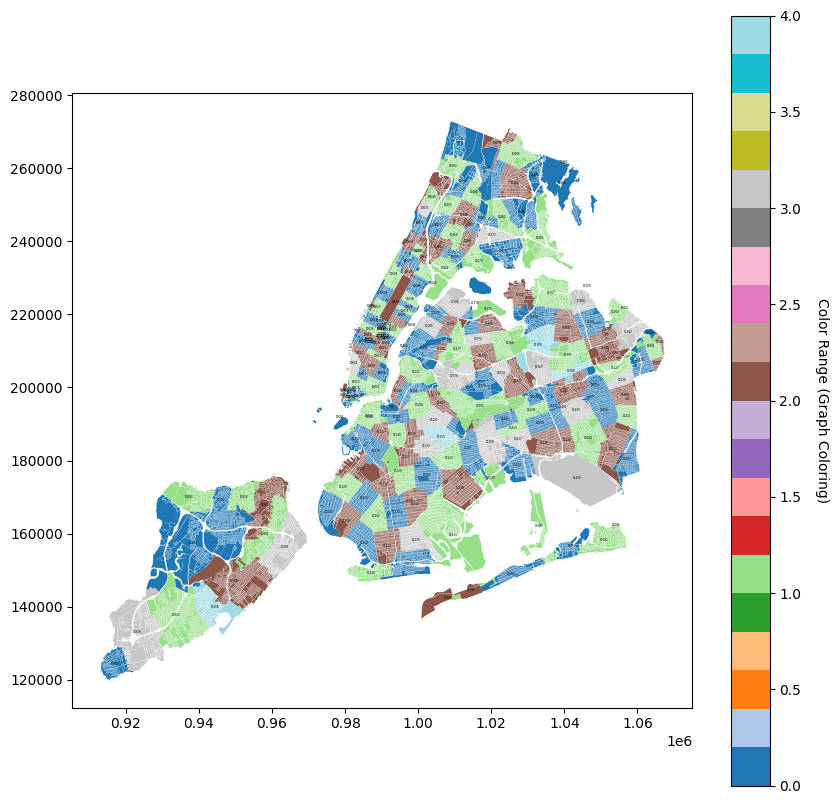

In [12]:
# Print the GeoDataFrame
print(gdf.head())

# Ensure that zip_code is preserved during the dissolve process
merged_gdf = gdf.dissolve(by='zip_code', aggfunc={'zip_code': 'first'})  # Explicit aggregation of zip_code

# Check if zip_code is now present after dissolving
print(merged_gdf.columns)  # Should include 'zip_code'

# Create a new adjacency graph based on the merged geometries
G = nx.Graph()

# Add nodes and edges based on adjacency of merged shapes
for i, shape1 in merged_gdf.iterrows():
    for j, shape2 in merged_gdf.iterrows():
        if i != j and shape1.geometry.touches(shape2.geometry):
            G.add_edge(i, j)

# Perform graph coloring to ensure adjacent shapes don't share the same color
color_map = nx.coloring.greedy_color(G, strategy="largest_first")

# Plot the map with the colors assigned
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Normalize the color map to cover the full range of the node indices
norm = mcolors.Normalize(vmin=min(color_map.values()), vmax=max(color_map.values()))
sm = plt.cm.ScalarMappable(cmap=plt.cm.tab20, norm=norm)

# Color the merged geometries based on the graph coloring using the full palette
merged_gdf['color'] = merged_gdf.index.map(color_map)
merged_gdf.plot(ax=ax, color=[sm.to_rgba(i) for i in merged_gdf['color']], edgecolor='black', linewidth=0, legend=False)

# Add labels at the center of each merged shape
for _, row in merged_gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, str(row['zip_code']), fontsize=2, ha='center', va='center')

# Add a colorbar to visualize the full range of colors
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Color Range (Graph Coloring)', rotation=270, labelpad=20)

plt.savefig(f"{PROJECT_DATA}/figures/map_output_zip_shuffled2.pdf", format="pdf")

plt.show()

In [28]:
import colorsys
import random
from shapely.geometry import LineString, Polygon
from shapely.ops import nearest_points

def darken_color(color, factor=0.8):
    """Darken an RGB or RGBA color by a given factor while preserving the hue."""
    r, g, b, *a = color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l *= factor  # Reduce brightness
    dark_color = colorsys.hls_to_rgb(h, l, s)
    return (*dark_color, *a)  # Preserve alpha if present

def generate_random_color():
    """
    Generate a random RGB color using HSL space.
    Returns an (R, G, B, A) tuple.
    """
    hue = random.uniform(0, 1)  # Hue: 0 to 1
    saturation = random.uniform(0.2, 1)  # Saturation: Keep colors vibrant
    lightness = random.uniform(0.2, 0.8)  # Lightness: Avoid extremes
    r, g, b = colorsys.hls_to_rgb(hue, lightness, saturation)
    return (r, g, b, 1.0)  # Include alpha channel


def enforce_color_contrast(colors, adjacency_graph, hue_threshold=0.15, brightness_threshold=0.2):
    """
    Adjust colors to ensure sufficient contrast between adjacent nodes.
    """
    adjusted_colors = colors.copy()

    def calculate_hue_brightness(color):
        """Convert an RGB color to (hue, brightness)."""
        r, g, b, _ = color
        h, l, _ = colorsys.rgb_to_hls(r, g, b)
        return h, l

    for node in adjacency_graph.nodes:
        current_color = adjusted_colors[node]
        current_hue, current_brightness = calculate_hue_brightness(current_color)

        for neighbor in adjacency_graph.neighbors(node):
            neighbor_color = adjusted_colors[neighbor]
            neighbor_hue, neighbor_brightness = calculate_hue_brightness(neighbor_color)

            # If adjacent colors are too similar, regenerate the color
            while (
                abs(current_hue - neighbor_hue) < hue_threshold
                and abs(current_brightness - neighbor_brightness) < brightness_threshold
            ):
                adjusted_colors[neighbor] = generate_random_color()
                neighbor_color = adjusted_colors[neighbor]
                neighbor_hue, neighbor_brightness = calculate_hue_brightness(neighbor_color)

    return adjusted_colors


def map_with_optimized_labels_and_lines(gdf, colname, outfile, format='pdf', n_colors=10):
    # Dissolve GeoDataFrame for unique values
    gdf = gdf.dissolve(by=colname, aggfunc={colname: 'first'})
    fig, ax = plt.subplots(figsize=(10, 10))

    # Assign unique colors for each region
    colormap = [plt.cm.tab20(i / 20) for i in range(n_colors)]
    gdf['mapped_color'] = [colormap[i % n_colors] for i in range(len(gdf))]

    # Plot the GeoDataFrame
    gdf.plot(
        ax=ax,
        color=gdf['mapped_color'],
        edgecolor='black',
        linewidth=0.1,
        legend=False
    )

    # Initialize labels and leader lines
    texts = []
    colors = []
    leader_line_data = []

    for _, row in gdf.iterrows():
        shape = row.geometry
        label_color = row['mapped_color']
        label = f"{row[colname]}"
        centroid = shape.centroid

        # Initial label position slightly displaced from centroid
        initial_x, initial_y = centroid.x + 500, centroid.y + 500
        text = ax.text(
            initial_x,
            initial_y,
            label,
            fontsize=2,
            ha='center',
            va='center',
            color='black',
            bbox=dict(
                facecolor=darken_color(label_color, factor=0.8),
                edgecolor='black',
                boxstyle='round,pad=0.1',
                alpha=0.5,
                linewidth=0.001
            ),
            zorder=3
        )
        texts.append(text)
        colors.append(label_color)
        leader_line_data.append((shape, (initial_x, initial_y)))

    # Adjust label positions using adjust_text
    adjust_text(
        texts,
        ax=ax,
        force_text=0.6,  # Stronger repulsion between text labels
        force_objects=0.2,  # Reduce repulsion from shapes
        expand=(1.2, 1.2),  # Expand bounding boxes slightly
        only_move={'points': 'xy'}  # Allow movement in all directions
    )

    # Draw leader lines connecting the nearest point on the shape to the adjusted label position
    for text, (shape, initial_label_pos), color in zip(texts, leader_line_data, colors):
        adjusted_label_pos = text.get_position()

        # Skip leader line if the label is fully inside the shape
        if shape.contains(Point(adjusted_label_pos)):
            continue

        # Find the nearest point on the shape boundary
        nearest_edge_point = nearest_points(shape.boundary, Point(adjusted_label_pos))[0]

        # Calculate control point for the leader line
        control_point_x = (nearest_edge_point.x + adjusted_label_pos[0]) / 2
        control_point_y = (nearest_edge_point.y + adjusted_label_pos[1]) / 2

        # Draw bent leader line: nearest edge -> control point -> adjusted label position
        ax.plot(
            [nearest_edge_point.x, control_point_x], [nearest_edge_point.y, control_point_y],
            color=color, linestyle='-', linewidth=0.25, zorder=2
        )
        ax.plot(
            [control_point_x, adjusted_label_pos[0]], [control_point_y, adjusted_label_pos[1]],
            color=color, linestyle='-', linewidth=0.25, zorder=2
        )

    # Save the plot
    plt.savefig(outfile, format=format)
    plt.show()


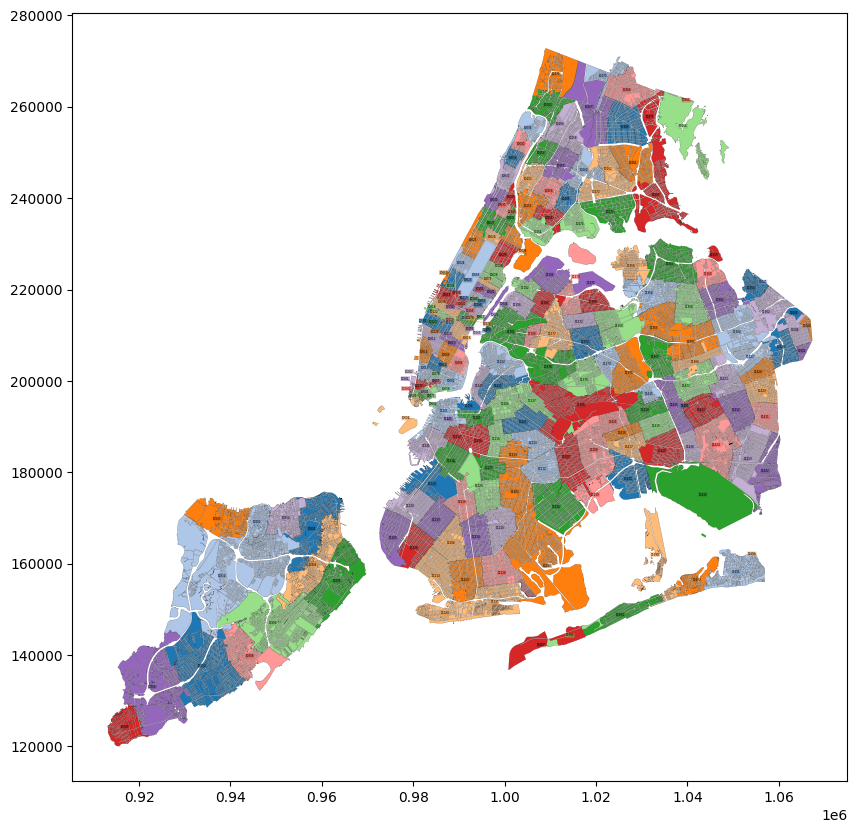

In [29]:
savepath = "/mnt/Datasets/PROJECTDATA/nyc_real_estate_data/figures/map_output_zip_bent_lines_adjacency_max.pdf"


map_with_optimized_labels_and_lines(gdf=gdf, colname='zip_code', outfile=savepath, format='pdf')